In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

import random

random.seed(10)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error


In [2]:
B = pd.read_csv(r'oos_validation_data.csv')  # validation set
B = B.drop(B.iloc[:,36:68],axis = 1)

C = pd.read_csv(r'development_data.csv') # unmasked set / training set
C = C.drop(C.iloc[:,36:68],axis = 1)

D = pd.read_csv(r'masked_forecasting_data.csv')  # masked set / test set
D = D.drop(D.iloc[:,36:68],axis = 1)

C = C.drop(columns=['eDWID'])
X_train = C.loc[:, C.columns != 'FIES']
y_train = C['FIES']
D = D.drop(columns=['eDWID'])
X_test = D.loc[:, D.columns != 'FIES']
y_test = D['FIES']


In [3]:
X_train_rnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1) # reshape train data to 3 dim input

def OptimalCutoff(pred, y_test):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
    i = np.arange(len(tpr))  # index for df
    roc = pd.DataFrame({
        'fpr': pd.Series(fpr, index=i),
        'tpr': pd.Series(tpr, index=i),
        '1-fpr': pd.Series(1 - fpr, index=i),
        'tf': pd.Series(tpr - (1 - fpr), index=i),
        'thresholds': pd.Series(thresholds, index=i)
    })
    
    roc_t = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]
      
    return list(roc_t['thresholds'])

def RNNTOP(units):

    RNN = Sequential()
            
    RNN.add(LSTM(units = units, return_sequences = True, input_shape = (34, 1))) 
    RNN.add(Dropout(0.2))
    
    RNN.add(Dense(units = 1))
    
    RNN.compile(optimizer= 'adam', loss = 'mean_squared_error',  metrics=['accuracy'])
    
    history = RNN.fit(X_train_rnn, y_train, epochs = 25, batch_size = 64) # train
    
    preds = RNN.predict(X_test) 
    
    c = OptimalCutoff(preds[:,0,0], y_test)
    
    y_pred = np.zeros(len(preds))
    for i in range(len(preds)):
        if preds[[i]][0][0] >= c:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
            
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

    return RMSE


In [ ]:

def create_rnn_model():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(34, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Regression output
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Create Keras classifier
model = KerasClassifier(model=create_rnn_model)

# Define hyperparameters to tune
param_grid = {
    'epochs': [25, 50, 75, 100],
    'batch_size': [16, 32, 64, 128]
}

# Perform grid search
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs = -1)
grid_result = grid_search.fit(X_train_rnn, y_train)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

2024-11-06 20:43:20.436983: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 20:43:20.437957: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 20:43:20.442710: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 20:43:20.455223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 20:43:20.475149: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Epoch 1/100
Epoch 1/100
Epoch 1/50
Epoch 1/75
Epoch 1/100


2024-11-06 20:43:32.872518: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-11-06 20:43:32.907548: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-06 20:43:32.929452: E external/local_xla/x

Epoch 1/50
Epoch 1/50
Epoch 1/50


2024-11-06 20:43:33.292107: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-06 20:43:33.292107: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-06 20:43:33.297989: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-06 20:43:33.301321: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-06 20:43:33.301314: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/

Epoch 1/50
Epoch 1/50
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/100


/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarni

Epoch 1/25
Epoch 1/75
Epoch 1/50
Epoch 1/100
Epoch 1/50
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/25
Epoch 1/100
Epoch 1/100
Epoch 1/75
Epoch 1/25
Epoch 1/50
Epoch 1/50
Epoch 1/100
Epoch 1/25
Epoch 1/25
Epoch 1/50
Epoch 1/50
Epoch 1/75
Epoch 1/100
Epoch 1/100
Epoch 1/50
Epoch 1/25
Epoch 1/100
Epoch 1/100
Epoch 1/25
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/50
Epoch 1/50
Epoch 1/75
Epoch 1/100
Epoch 1/100
3677/3677 ━━━━━━━━━━━━━━━━━━━━ 193s 52ms/step - accuracy: 0.7323 - loss: 0.196517
 2904/14706 ━━━━━━━━━━━━━━━━━━━━ 12:40 64ms/step - accuracy: 0.7065 - loss: 0.1983Epoch 2/100
3677/3677 ━━━━━━━━━━━━━━━━━━━━ 194s 52ms/step - accuracy: 0.7206 - loss: 0.1964981
3590/3677 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.7330 - loss: 0.1824Epoch 2/100
3677/3677 ━━━━━━━━━━━━━━━━━━━━ 194s 52ms/step - accuracy: 0.7469 - loss: 0.17881415
 3892/14706 ━━━━━━━━━━━━━━━━━━━━ 8:41 48ms/step - accuracy: 0.7186 - loss: 0.1937Epoch 2/50
3677/3677 ━━━━━━━━━━━━━━━━━━━━ 195s 52ms/step - accuracy: 0.7387

In [34]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.812770 using {'epochs': 25, 'batch_size': 32}


In [36]:

def create_rnn_model(neurons):
    model = Sequential()
    model.add(LSTM(units=neurons, input_shape=(34, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Regression output
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Create Keras classifier
model = KerasClassifier(model=create_rnn_model, epochs = 25, batch_size = 32)

# Define hyperparameters to tune
neurons = [1, 5, 10, 20, 25, 30, 35, 40, 45, 50]
param_grid = dict(model__neurons=neurons)

# Perform grid search
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs = -1)
grid_result = grid_search.fit(X_train_rnn, y_train)


2024-11-07 15:40:36.720378: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 15:40:36.720390: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 15:40:36.720377: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 15:40:36.720385: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

Epoch 1/25
Epoch 1/25


/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarni

Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
14706/14706 ━━━━━━━━━━━━━━━━━━━━ 160s 11ms/step - accuracy: 0.6026 - loss: 0.2621
Epoch 2/25
14706/14706 ━━━━━━━━━━━━━━━━━━━━ 164s 11ms/step - accuracy: 0.6010 - loss: 0.3436
Epoch 2/25
14706/14706 ━━━━━━━━━━━━━━━━━━━━ 211s 14ms/step - accuracy: 0.7079 - loss: 0.1910
Epoch 2/25
14706/14706 ━━━━━━━━━━━━━━━━━━━━ 221s 15ms/step - accuracy: 0.7434 - loss: 0.1778
 8926/14706 ━━━━━━━━━━━━━━━━━━━━ 2:22 25ms/step - accuracy: 0.7367 - loss: 0.1809Epoch 2/25
14706/14706 ━━━━━━━

/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 121s 6ms/step - accuracy: 0.7196 - loss: 0.1881
Epoch 2/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step - accuracy: 0.7941 - loss: 0.1465
Epoch 3/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 124s 7ms/step - accuracy: 0.7986 - loss: 0.1420
Epoch 4/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 115s 6ms/step - accuracy: 0.8033 - loss: 0.1376
Epoch 5/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step - accuracy: 0.8055 - loss: 0.1364
Epoch 6/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 113s 6ms/step - accuracy: 0.8089 - loss: 0.1339
Epoch 7/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.8104 - loss: 0.1327
Epoch 8/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 110s 6ms/step - accuracy: 0.8113 - loss: 0.1323
Epoch 9/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.8114 - loss: 0.1322
Epoch 10/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step - accuracy: 0.8126 - loss: 0.1311
Epoch 11/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.8127 -

In [37]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.819196 using {'model__neurons': 10}


In [39]:

def create_rnn_model(dropout_rate):
    model = Sequential()
    model.add(LSTM(units=10, input_shape=(34, 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))  # Regression output
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Create Keras classifier
model = KerasClassifier(model=create_rnn_model, epochs = 25, batch_size = 32)

# Define hyperparameters to tune
dropout = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
param_grid = dict(model__dropout_rate=dropout)

# Perform grid search
grid_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs = -1)
grid_result = grid_search.fit(X_train_rnn, y_train)


/usr/local/python3/3.12.3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
2024-11-07 18:38:09.467937: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-07 18:38:09.467937: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-07 18:38:09.467937: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-07 18:38:09.469372: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-07 18:38:09.475088: E external/local_xla/xla/st

Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
Epoch 1/25
    9/14706 ━━━━━━━━━━━━━━━━━━━━ 3:25 14ms/step - accuracy: 0.3617 - loss: 1.63318

2024-11-07 18:38:11.748777: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-07 18:38:11.748978: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-07 18:38:11.748975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-07 18:38:11.749004: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-07 18:38:11.750165: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-07 18:38:11.750747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-07 18:38:11.750767: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-07 18:38:11.750770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-

  359/14706 ━━━━━━━━━━━━━━━━━━━━ 2:55 12ms/step - accuracy: 0.5163 - loss: 0.8000

2024-11-07 18:38:16.234563: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-07 18:38:16.234936: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-07 18:38:16.245294: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-07 18:38:16.249042: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-07 18:38:16.273694: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-07 18:38:16.278450: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO

  422/14706 ━━━━━━━━━━━━━━━━━━━━ 2:47 12ms/step - accuracy: 0.4558 - loss: 0.5985

/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  426/14706 ━━━━━━━━━━━━━━━━━━━━ 2:47 12ms/step - accuracy: 0.4563 - loss: 0.5966Epoch 1/25
  436/14706 ━━━━━━━━━━━━━━━━━━━━ 2:48 12ms/step - accuracy: 0.5313 - loss: 0.3571Epoch 1/25
  432/14706 ━━━━━━━━━━━━━━━━━━━━ 2:46 12ms/step - accuracy: 0.5322 - loss: 0.2823Epoch 1/25
  446/14706 ━━━━━━━━━━━━━━━━━━━━ 2:33 11ms/step - accuracy: 0.4882 - loss: 0.4299Epoch 1/25
  408/14706 ━━━━━━━━━━━━━━━━━━━━ 2:51 12ms/step - accuracy: 0.5308 - loss: 0.3981Epoch 1/25
  444/14706 ━━━━━━━━━━━━━━━━━━━━ 2:37 11ms/step - accuracy: 0.4184 - loss: 0.7305Epoch 1/25
  417/14706 ━━━━━━━━━━━━━━━━━━━━ 2:52 12ms/step - accuracy: 0.4486 - loss: 1.1017Epoch 1/25
Epoch 1/25
  440/14706 ━━━━━━━━━━━━━━━━━━━━ 2:48 12ms/step - accuracy: 0.5316 - loss: 0.3565Epoch 1/25
  438/14706 ━━━━━━━━━━━━━━━━━━━━ 2:48 12ms/step - accuracy: 0.4844 - loss: 0.4210Epoch 1/25
Epoch 1/25
  436/14706 ━━━━━━━━━━━━━━━━━━━━ 2:46 12ms/step - accuracy: 0.5324 - loss: 0.2821Epoch 1/25
Epoch 1/25
  425/14706 ━━━━━━━━━━━━━━━━━━━━ 2:47 12ms/step

/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 121s 7ms/step - accuracy: 0.6845 - loss: 0.2108
Epoch 2/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 116s 6ms/step - accuracy: 0.7974 - loss: 0.1414
Epoch 3/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 121s 7ms/step - accuracy: 0.8051 - loss: 0.1366
Epoch 4/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 120s 7ms/step - accuracy: 0.8076 - loss: 0.1342
Epoch 5/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 120s 7ms/step - accuracy: 0.8106 - loss: 0.1326
Epoch 6/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 120s 7ms/step - accuracy: 0.8111 - loss: 0.1319
Epoch 7/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.8130 - loss: 0.1313
Epoch 8/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 121s 7ms/step - accuracy: 0.8132 - loss: 0.1309
Epoch 9/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 123s 7ms/step - accuracy: 0.8124 - loss: 0.1311
Epoch 10/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 129s 7ms/step - accuracy: 0.8149 - loss: 0.1301
Epoch 11/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 128s 7ms/step - accuracy: 0.8151 -

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.816755 using {'model__dropout_rate': 0.2}


In [47]:
def RNNLAY(layers):
    RNN = Sequential()
    if layers == 1:
        RNN.add(LSTM(units = 10, input_shape = (34, 1))) 
        RNN.add(Dropout(0.2))
    if layers == 2:
        RNN.add(LSTM(units = 10, return_sequences = True))
        RNN.add(Dropout(0.2))
        RNN.add(LSTM(units = 10))
        RNN.add(Dropout(0.2))
    if layers == 3:
        RNN.add(LSTM(units = 10, return_sequences = True, input_shape = (34, 1)))
        RNN.add(Dropout(0.2))
        RNN.add(LSTM(units = 10, return_sequences = True))
        RNN.add(Dropout(0.2))
        RNN.add(LSTM(units = 10))
        RNN.add(Dropout(0.2))
    elif layers == 4:
        RNN.add(LSTM(units = 10, return_sequences = True, input_shape = (34, 1)))
        RNN.add(Dropout(0.2))
        RNN.add(LSTM(units = 10, return_sequences = True))
        RNN.add(Dropout(0.2))
        RNN.add(LSTM(units = 10, return_sequences = True))
        RNN.add(Dropout(0.2))
        RNN.add(LSTM(units = 10))
        RNN.add(Dropout(0.2))
    
    RNN.add(Dense(units = 1))
    
    RNN.compile(optimizer= 'adam', loss = 'mean_squared_error',  metrics=['accuracy'])
    
    history = RNN.fit(X_train_rnn, y_train, epochs = 25, batch_size = 32) # train
    
    preds = RNN.predict(X_test) 
    
    # find best cut off point of probability for 0 or 1
    def OptimalCutoff(pred): # since NN predictions are probabilities we have to find the best cut off point to make those hard predictions
        fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
        i = np.arange(len(tpr)) # index for df
        roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
        roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
            
        return list(roc_t['thresholds'])
    
    c = OptimalCutoff(preds)
    
    y_pred = np.zeros(len(preds))
    for i in range(len(preds)):
        if preds[[i]][0][0] >= c:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
            

    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    return RMSE



In [48]:
one = RNNLAY(1)
two = RNNLAY(2)
three = RNNLAY(3)
four = RNNLAY(4)

/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 124s 7ms/step - accuracy: 0.7308 - loss: 0.1842
Epoch 2/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 123s 7ms/step - accuracy: 0.7971 - loss: 0.1423
Epoch 3/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 122s 7ms/step - accuracy: 0.8034 - loss: 0.1372
Epoch 4/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 124s 7ms/step - accuracy: 0.8090 - loss: 0.1342
Epoch 5/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 124s 7ms/step - accuracy: 0.8101 - loss: 0.1330
Epoch 6/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 125s 7ms/step - accuracy: 0.8115 - loss: 0.1321
Epoch 7/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.8129 - loss: 0.1315
Epoch 8/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 120s 7ms/step - accuracy: 0.8144 - loss: 0.1308
Epoch 9/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 118s 6ms/step - accuracy: 0.8137 - loss: 0.1307
Epoch 10/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 119s 6ms/step - accuracy: 0.8144 - loss: 0.1303
Epoch 11/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 126s 7ms/step - accuracy: 0.8147 -

/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 360s 19ms/step - accuracy: 0.7495 - loss: 0.1724
Epoch 2/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 350s 19ms/step - accuracy: 0.8047 - loss: 0.1366
Epoch 3/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 357s 19ms/step - accuracy: 0.8069 - loss: 0.1343
Epoch 4/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 375s 20ms/step - accuracy: 0.8116 - loss: 0.1311
Epoch 5/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 346s 19ms/step - accuracy: 0.8128 - loss: 0.1305
Epoch 6/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 366s 20ms/step - accuracy: 0.8139 - loss: 0.1292
Epoch 7/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 359s 20ms/step - accuracy: 0.8143 - loss: 0.1291
Epoch 8/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 371s 20ms/step - accuracy: 0.8150 - loss: 0.1287
Epoch 9/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 365s 20ms/step - accuracy: 0.8172 - loss: 0.1276
Epoch 10/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 363s 20ms/step - accuracy: 0.8171 - loss: 0.1277
Epoch 11/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 351s 19ms/step - accurac

/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 491s 26ms/step - accuracy: 0.7377 - loss: 0.1765
Epoch 2/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 489s 27ms/step - accuracy: 0.8017 - loss: 0.1381
Epoch 3/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 492s 27ms/step - accuracy: 0.8091 - loss: 0.1325
Epoch 4/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 483s 26ms/step - accuracy: 0.8123 - loss: 0.1307
Epoch 5/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 487s 26ms/step - accuracy: 0.8137 - loss: 0.1294
Epoch 6/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 494s 27ms/step - accuracy: 0.8148 - loss: 0.1292
Epoch 7/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 488s 27ms/step - accuracy: 0.8156 - loss: 0.1286
Epoch 8/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 488s 27ms/step - accuracy: 0.8163 - loss: 0.1283
Epoch 9/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 492s 27ms/step - accuracy: 0.8158 - loss: 0.1285
Epoch 10/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 478s 26ms/step - accuracy: 0.8163 - loss: 0.1281
Epoch 11/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 490s 27ms/step - accurac

In [50]:
l = list([one, two, three, four])
m = min(l)
m
l.index(m)

2

In [54]:
l

[0.40082144285603294,
 0.3983227913293522,
 0.39752130115104833,
 0.3989836775223776]

In [55]:
#X_train_rnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1) # reshape train data to 3 dim input

RNN = Sequential()
        
RNN.add(LSTM(units = 10, return_sequences = True, input_shape = (34, 1))) 
RNN.add(Dropout(0.2))

RNN.add(LSTM(units = 10, return_sequences=True))
RNN.add(Dropout(0.2))

RNN.add(LSTM(units = 10))
RNN.add(Dropout(0.2))

RNN.add(Dense(units = 1))

RNN.compile(optimizer= 'adam', loss = 'mean_squared_error',  metrics=['accuracy'])

history = RNN.fit(X_train_rnn, y_train, epochs = 25, batch_size = 32) # train

preds = RNN.predict(X_test) 
preds


ppdevrnn = pd.DataFrame(preds)
# ppdevrnn.to_excel("PredictedProbabilitiesDevRNN.xlsx")



# find best cut off point of probability for 0 or 1
def OptimalCutoff(pred): # since NN predictions are probabilities we have to find the best cut off point to make those hard predictions
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
        
    return list(roc_t['thresholds'])

c = OptimalCutoff(preds)

y_pred = np.zeros(len(preds))
for i in range(len(preds)):
    if preds[[i]][0][0] >= c:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
        
# Validation

cm = metrics.confusion_matrix(y_test, y_pred)
    
def misclassificationrate(cm):
    error = cm[0,1] + cm[1,0]
    total = cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]
    mr = error / total * 100
    return round(mr, 2)
    
def Sensitivity(cm):
    sen = cm[0,0]/(cm[0,0]+cm[0,1])
    return sen
    
def Specificity(cm):
    spe = cm[1,1]/(cm[1,0]+cm[1,1])
    return spe
    
mr = misclassificationrate(cm)
sen = Sensitivity(cm)
spe = Specificity(cm)
mr
sen
spe

auc = metrics.roc_auc_score(y_test, preds[:,0][:][:][:])
auc

/usr/local/python3/3.12.3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 370s 20ms/step - accuracy: 0.7488 - loss: 0.1701
Epoch 2/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 361s 20ms/step - accuracy: 0.8061 - loss: 0.1343
Epoch 3/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 369s 20ms/step - accuracy: 0.8099 - loss: 0.1319
Epoch 4/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 359s 20ms/step - accuracy: 0.8122 - loss: 0.1302
Epoch 5/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 360s 20ms/step - accuracy: 0.8134 - loss: 0.1295
Epoch 6/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 373s 20ms/step - accuracy: 0.8155 - loss: 0.1286
Epoch 7/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 367s 20ms/step - accuracy: 0.8163 - loss: 0.1281
Epoch 8/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 370s 20ms/step - accuracy: 0.8163 - loss: 0.1281
Epoch 9/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 365s 20ms/step - accuracy: 0.8160 - loss: 0.1284
Epoch 10/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 365s 20ms/step - accuracy: 0.8165 - loss: 0.1278
Epoch 11/25
18383/18383 ━━━━━━━━━━━━━━━━━━━━ 367s 20ms/step - accurac

0.9195104315558799

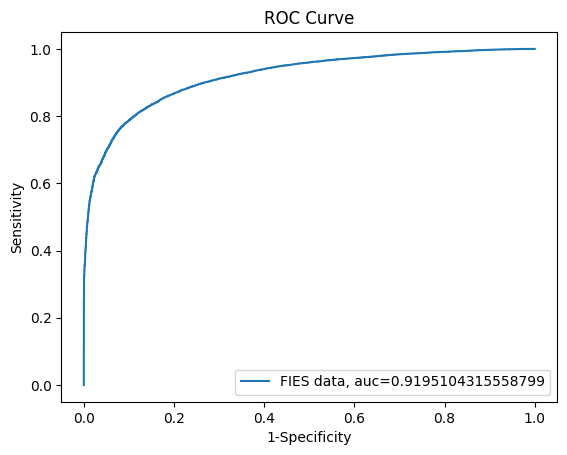

In [56]:
fig, ax = plt.subplots()
fpr, tpr, _ = metrics.roc_curve(y_test,  preds[:,0][:][:][:])
plt.plot(fpr,tpr,label="FIES data, auc="+str(auc))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()


In [57]:

print('AUC', auc)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Sensitivity", sen)
print('Specificity', spe)
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

AUC 0.9195104315558799
Accuracy: 0.8401741638471352
Sensitivity 0.8402906878485719
Specificity 0.8401512889419728
Precision: 0.9640246687985381
Recall: 0.8401512889419728


In [58]:
B = B.drop(columns=['eDWID'])
# Use set B for external cross validation
XB = B.loc[:, B.columns != 'FIES']
yB = B['FIES']


# Cross validation on set Bs predictions vs the true values in set B
def CrossValExt(pred):        
    cm = metrics.confusion_matrix(yB, pred)
    auc = metrics.roc_auc_score(yB, pred)
    sen = Sensitivity(cm)
    spe = Specificity(cm)
    
    # ROC Curve plot
    fig, ax = plt.subplots()
    fpr, tpr, _ = metrics.roc_curve(yB,  pred)
    plt.plot(fpr,tpr,label="FIES data, auc="+str(auc))
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC Curve')
    plt.legend(loc=4)
    plt.show()
    
    print('AUC', auc)
    print("Accuracy:",metrics.accuracy_score(yB, pred))
    print("Sensitivity", sen)
    print('Specificity', spe)
    print("Precision:",metrics.precision_score(yB, pred))
    print("Recall:",metrics.recall_score(yB, pred))


4874/4874 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step


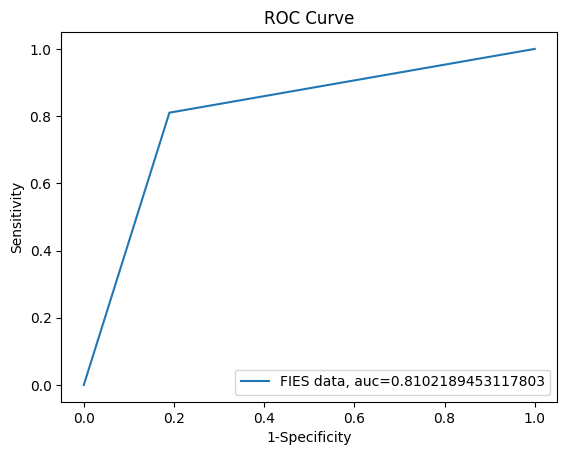

AUC 0.8102189453117803
Accuracy: 0.8102178080698628
Sensitivity 0.8102222569430881
Specificity 0.8102156336804727
Precision: 0.8972789547126728
Recall: 0.8102156336804727


In [59]:
yre = RNN.predict(XB)

def OptimalCutoffANN(pred): # since NN predictions are probabilities we have to find the best cut off point to make those hard predictions
    fpr, tpr, thresholds = metrics.roc_curve(yB, pred)
    i = np.arange(len(tpr)) # index for df
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
        
    return list(roc_t['thresholds'])

d = OptimalCutoffANN(yre[:,0])

y_pred_r = np.zeros(len(yre[:,0]))
for i in range(len(yre[:,0])):
    if yre[:,0][i] >= d: # may have to adjust value based on above threshold value
        y_pred_r[i] = 1
    else:
        y_pred_r[i] = 0
        
CrossValExt(y_pred_r)

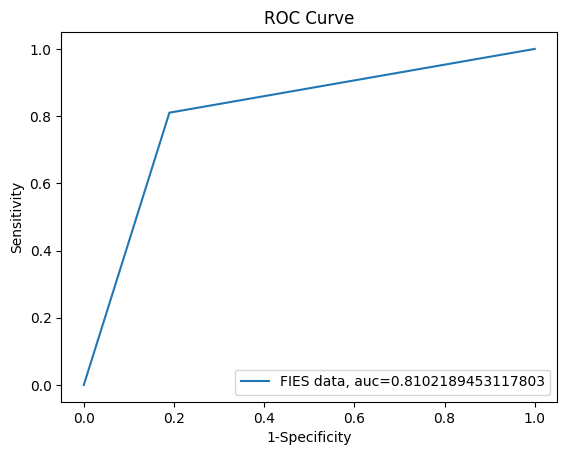

In [61]:
def CrossValExt(pred):        
    cm = metrics.confusion_matrix(yB, pred)
    auc = metrics.roc_auc_score(yB, pred)
    sen = Sensitivity(cm)
    spe = Specificity(cm)
    
    # ROC Curve plot
    fig, ax = plt.subplots()
    fpr, tpr, _ = metrics.roc_curve(yB,  pred)
    plt.plot(fpr,tpr,label="FIES data, auc="+str(auc))
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC Curve')
    plt.legend(loc=4)
    plt.show()

CrossValExt(y_pred_r)